In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Load Images

In [ ]:
TRAIN_PATH = "./Data/data-science-bowl-2018/stage1_train/"
TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,
                   IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH,
                  IMG_CHANNELS), dtype=np.uint8)


### Resizing training images and masks

- Data is saved to X_train and Y_train -> just load them


In [6]:
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): #tqdm shows progress bar
#     path = TRAIN_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img  # Fill empty X_train with values from img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(
#             mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)

#     Y_train[n] = mask


In [7]:
# np.save("Train_Images", X_train)
# np.save("Train_Masks", Y_train)

X_train = np.load("Train_Images.npy")
Y_train = np.load("Train_Masks.npy")


### Resizing test images


In [8]:
sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):  # tqdm shows progress bar
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH),
                 mode='constant', preserve_range=True)
    X_test[n] = img


100%|██████████| 65/65 [00:01<00:00, 43.44it/s]


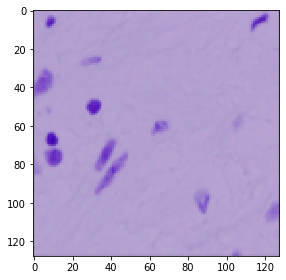

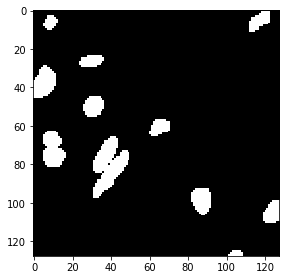

In [9]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


## Build model

In [10]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy',
#               metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Model Checkpoint

In [11]:
# checkpointer = ModelCheckpoint(
#     'model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks = [
#     EarlyStopping(patience=2, monitor='val_loss'),
#     TensorBoard(log_dir='logs')
# ]


## Train Model

In [12]:
# Siehe Test.py für Ablauf!



# results = model.fit(X_train, Y_train, validation_split=0.1,
#                     batch_size=16, epochs=1, callbacks=callbacks)


In [13]:
# Custom train loop

num_epochs = 1
optimizer = tf.keras.optimizers.Adam()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.binary_crossentropy
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


for epoch in range(num_epochs):
    print(f"Start of epoch {epoch}")
    for  (x_batch, y_batch) in tqdm(zip(X_train, Y_train), desc="training...", ascii=False, ncols=75):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch.reshape(-1, 128, 128, 3), training=True)
            loss = loss_fn(y_batch.reshape(-1, 128, 128, 1), y_pred)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        acc_metric.update_state(
            y_batch.reshape(-1, 128, 128, 1), y_pred)

    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {train_acc}")
    acc_metric.reset_states()


Start of epoch 0


training...: 123it [00:24,  4.81it/s]